# data dields:
- **id** - a unique identifier for each trip
- **vendor**_id - a code indicating the provider associated with the trip record
- **pickup_datetime** - date and time when the meter was engaged
- **dropoff_datetime** - date and time when the meter was disengaged
- **passenger_count** - the number of passengers in the vehicle (driver entered value)
- **pickup_longitude** - the longitude where the meter was engaged
- **pickup_latitude** - the latitude where the meter was engaged
- **dropoff_longitude** - the longitude where the meter was disengaged
- **dropoff_latitude** - the latitude where the meter was disengaged
- **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip trip_duration - duration of the trip in seconds

# Importing Libraries

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# Get Data 

In [3]:
base_dir = Path.cwd()
root_dir = base_dir.parent
data_file = root_dir / 'Data' / 'train.csv'
df = pd.read_csv(data_file)

# Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1000000 non-null  object 
 1   vendor_id           1000000 non-null  int64  
 2   pickup_datetime     1000000 non-null  object 
 3   passenger_count     1000000 non-null  int64  
 4   pickup_longitude    1000000 non-null  float64
 5   pickup_latitude     1000000 non-null  float64
 6   dropoff_longitude   1000000 non-null  float64
 7   dropoff_latitude    1000000 non-null  float64
 8   store_and_fwd_flag  1000000 non-null  object 
 9   trip_duration       1000000 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 76.3+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vendor_id,1000000.0,1.534793,0.498788,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1000000.0,1.665353,1.315723,0.000000,1.000000,1.000000,2.000000,7.000000e+00
pickup_longitude,1000000.0,-73.973475,0.065404,-121.933342,-73.991852,-73.981728,-73.967346,-6.133553e+01
pickup_latitude,1000000.0,40.750947,0.033745,34.359695,40.737372,40.754131,40.768379,5.188108e+01
dropoff_longitude,1000000.0,-73.973421,0.065432,-121.933304,-73.991341,-73.979767,-73.963036,-6.133553e+01
dropoff_latitude,1000000.0,40.751829,0.035782,34.359695,40.735928,40.754551,40.769833,4.392103e+01
trip_duration,1000000.0,954.884971,3882.070116,1.000000,397.000000,662.000000,1074.000000,2.227612e+06


In [6]:
df['store_and_fwd_flag'].value_counts(normalize=True)

store_and_fwd_flag
N    0.994443
Y    0.005557
Name: proportion, dtype: float64

In [7]:
df.duplicated().sum()

np.int64(0)

vendor_id has two classes 1 and 2 , represent the vechicle provider

passenger_count has minimum zero! and maximum 7!,but minimum passengers should be 1 and maximum passengers should be six(maybe it depends on taxi provider)

For NYC
Latitude:
Minimum: 40.49° N
Maximum: 40.92° N
Longitude:
Minimum: -74.27° W
Maximum: -73.68° W
but we have minimum pickup_lat = 34.359695 and maximum pickup_lat = 51.88108 , minimum pickup_lang = 121.933342 and maximum pickup_lang=-61.33553
trip_duration(target feature):has minimum 1 second and maximum 618.78 hours which represent very high outliers trip_duration has average 662.000000 seconds which represent 11 minute

store_and_fwd_flag has two values N indicate the data was sent to the server in real-time, Y represent it was stored in vechicle memory and sent later when connection back

## target feture

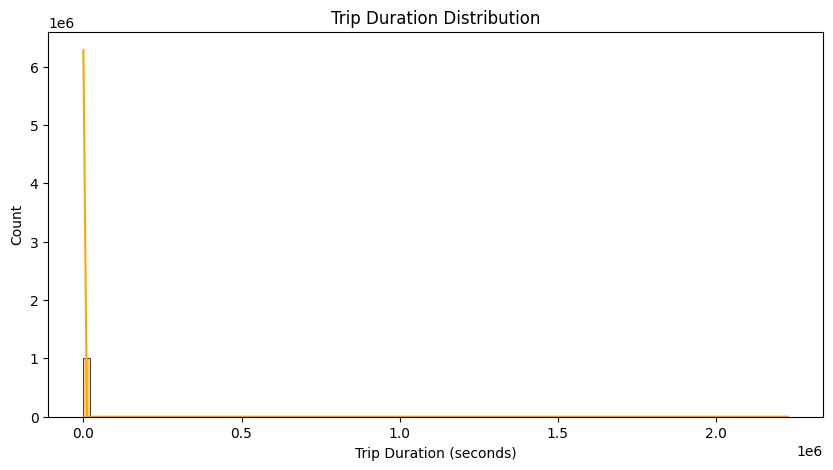

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(df['trip_duration'], bins=100, kde=True, color='orange')
plt.title('Trip Duration Distribution')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Count')
plt.show()

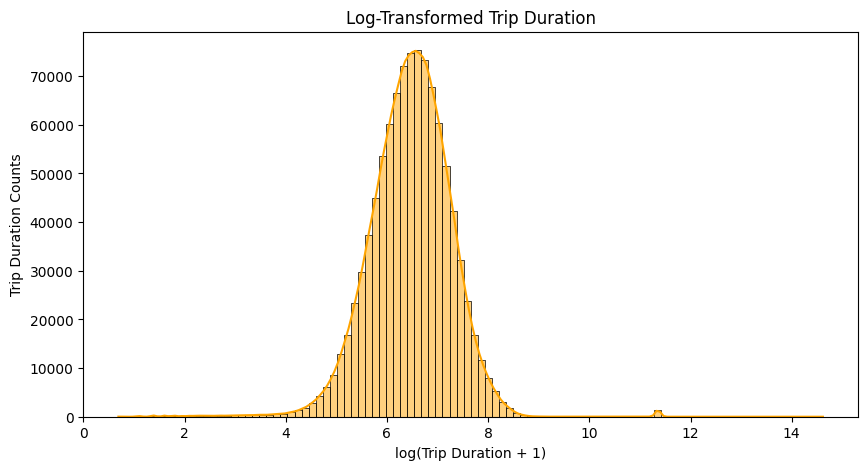

In [9]:
# we will apply log1p to trip duration to dominate the right skweness
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(df['trip_duration']), bins=100, kde=True, color='orange')
plt.title('Log-Transformed Trip Duration')
plt.xlabel('log(Trip Duration + 1)')
plt.ylabel('Trip Duration Counts')
plt.show()

most of data exist in range from 5 to 7 which equal to 2.5 minutes to 18.26 minutes

we see high skewed data from left and right (outliers)

## Explore Pickup DateTime

In [10]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [11]:
print(f'statring date : {min(df['pickup_datetime'] )} and last date : {max(df['pickup_datetime'] )}')
date_range = (df['pickup_datetime'].max() - df['pickup_datetime'].min()).days + 1
print(f"The date range: {date_range} days")

statring date : 2016-01-01 00:00:53 and last date : 2016-06-30 23:59:37
The date range: 182 days


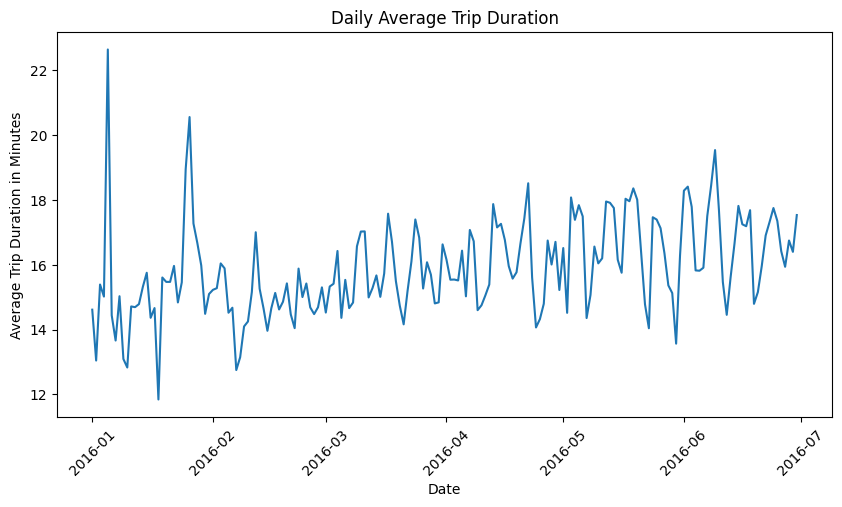

In [12]:
df['trip_duration_minute'] =  df['trip_duration'] / 60
group = df.groupby(df['pickup_datetime'].dt.date)['trip_duration_minute'].mean()
plt.figure(figsize=(10,5))
plt.plot(group.index, group.values)   # index = dates, values = mean trip duration
plt.xlabel('Date')
plt.ylabel('Average Trip Duration in Minutes')
plt.title('Daily Average Trip Duration')
plt.xticks(rotation=45)
plt.show()

In [13]:
# We don't need year column since it's one value 2016

df['pickup_month'] = df['pickup_datetime'].dt.month

df['pickup_day'] = df['pickup_datetime'].dt.day

df['pickup_hour'] = df['pickup_datetime'].dt.hour

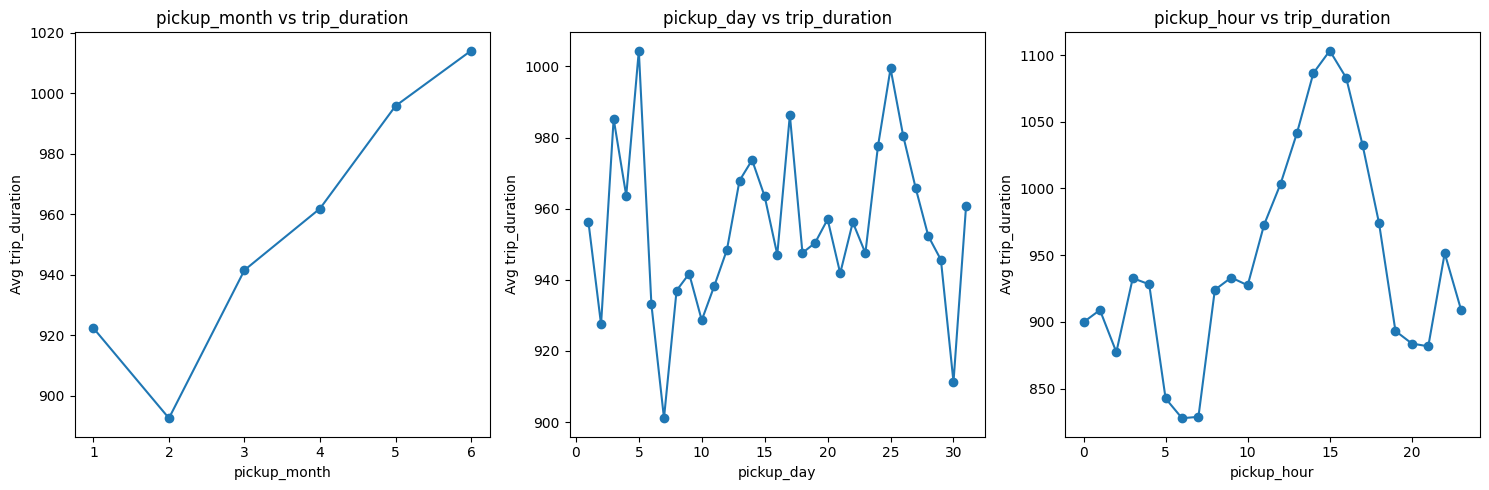

In [14]:
features = ['pickup_month', 'pickup_day', 'pickup_hour']
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    
    # Group by feature and take mean of trip_duration
    grouped = df.groupby(feature)['trip_duration'].mean()
    
    plt.plot(grouped.index, grouped.values, marker='o')
    plt.xlabel(feature)
    plt.ylabel("Avg trip_duration")
    plt.title(f"{feature} vs trip_duration")

plt.tight_layout()
plt.show()

we see that the trip duration withing 11 to 18 hours are high due to jam since it's the time of work and return from it

we see positive correlation between months and trip duration except month 2

In [15]:
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['is_weekend'] = df['pickup_weekday'].isin([5,6]).astype(int) # saturday and sunday
df['rush_hour'] = df['pickup_hour'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

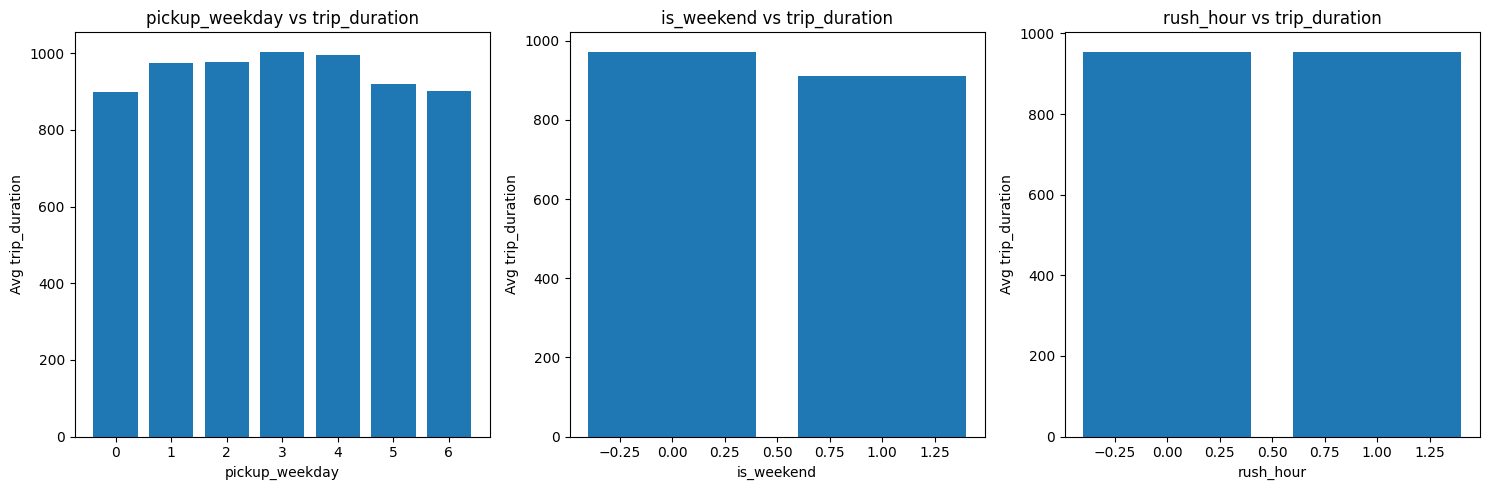

In [16]:
features = ['pickup_weekday', 'is_weekend', 'rush_hour']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features, 1):
    plt.subplot(1, 3, i)
    
    # Group by feature and take mean of trip_duration
    grouped = df.groupby(feature)['trip_duration'].mean()
    
    plt.bar(grouped.index, grouped.values)
    plt.xlabel(feature)
    plt.ylabel("Avg trip_duration")
    plt.title(f"{feature} vs trip_duration")

plt.tight_layout()
plt.show()

in weekend the traffic is quiet ,
we see monday is the quitiest day while thursday and friday the busiest



## Explore Latitude and Longitude


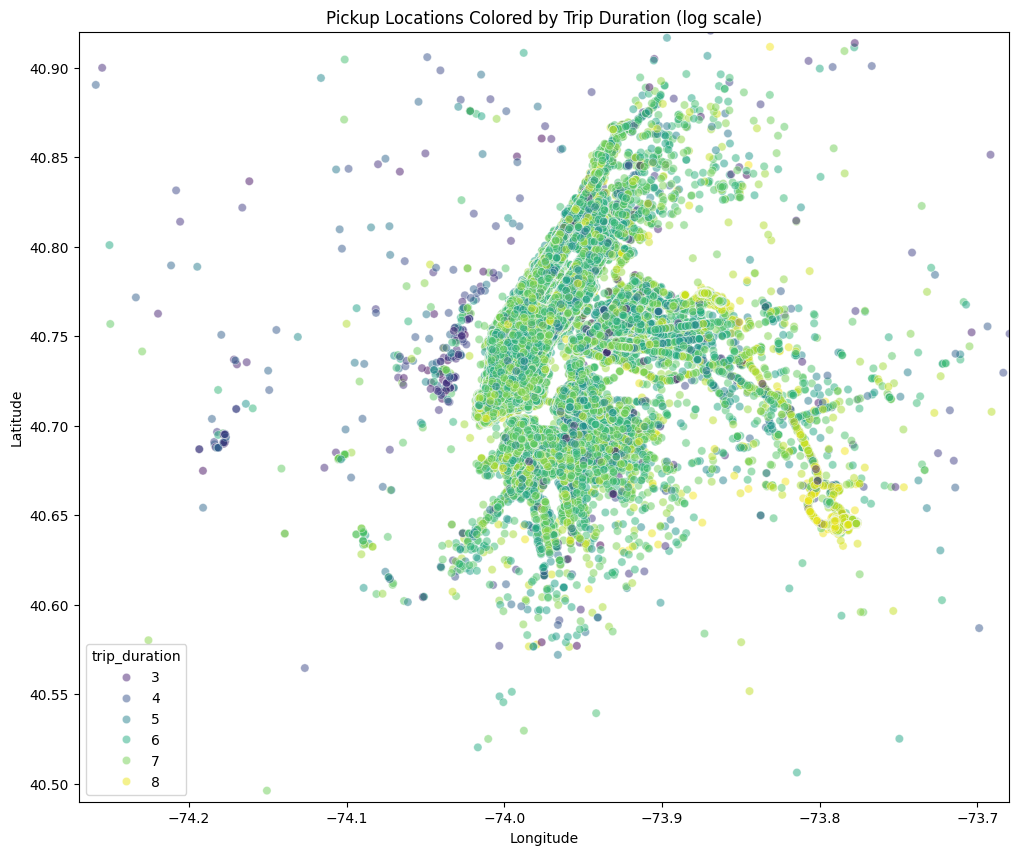

In [17]:
# Filter out extreme outliers
mask = (df['trip_duration'] <= 3600) & (df['trip_duration'] > 10)
filtered = df[mask]

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=filtered,
    x='pickup_longitude',
    y='pickup_latitude',
    hue=np.log1p(filtered['trip_duration']),  # log scale for color
    palette='viridis',
    alpha=0.5,
    legend=True
)
plt.title('Pickup Locations Colored by Trip Duration (log scale)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-74.27, -73.68)
plt.ylim(40.49, 40.92)
plt.show()

the yellow points represent high trip duration , which appear in bottom right, the JFK International Airport ,
 since the trip usually travel to outer place  

 **Eucludien distance**






In [18]:
# first we get the Eucludien distance
df["latitude_distance"]  = df["dropoff_latitude"]  -  df["pickup_latitude"]
df["longitude_distance"] = df["dropoff_longitude"] - df["pickup_longitude"]

df['euclidien_distance'] = np.sqrt(df["latitude_distance"]**2 + df["longitude_distance"]**2)

**Haversine Distances**

In [19]:
def haversine(lat1, lon1, lat2, lon2):
    # convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # Earth radius in km

In [20]:
# Apply data
df['haversine_distance'] = haversine(
    df['pickup_latitude'].values,
    df['pickup_longitude'].values,
    df['dropoff_latitude'].values,
    df['dropoff_longitude'].values
)

**Bearing( Direction )**

In [21]:
# this function compute the direction of the trip from 0 : 360
def compute_bearing(lat1,lon1,lat2,lon2):
    dlon = np.radians(lon2 - lon1)
    
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    
    # this compute the east-west component
    x = np.sin(dlon) * np.cos(lat2)

    # this compute the North-South component
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))

    # arctan compute the angle between x and y in radians 
    # np.degrees converts to degrees
    # + 360 and % 360 to make the angle within in range [0:360]
    return (np.degrees(np.arctan2(x, y)) + 360) % 360

In [22]:
df['bearing'] = compute_bearing(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"]
)

**Manhattan Distance**

In [23]:
df['manhattan_distance'] = np.abs(df["latitude_distance"]) + np.abs(df["longitude_distance"])

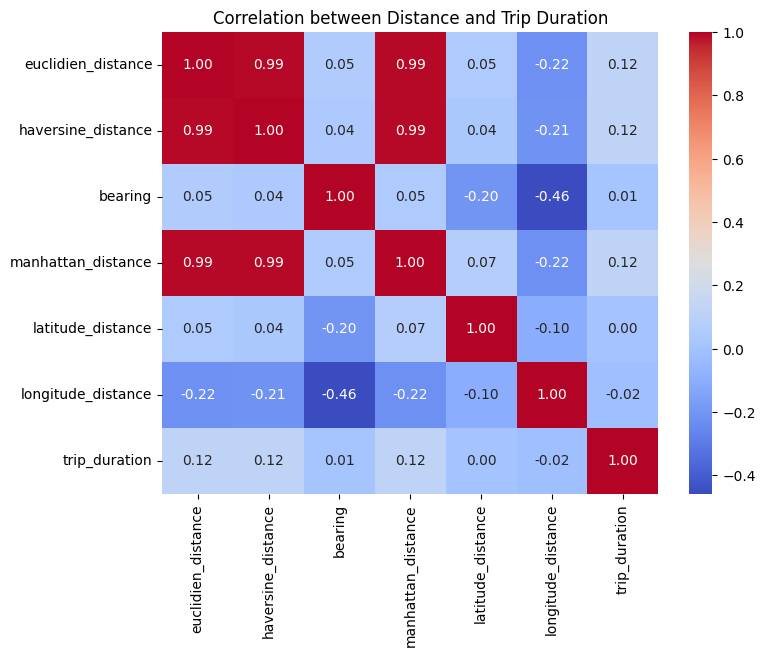

In [24]:
corr = df[['euclidien_distance','haversine_distance','bearing','manhattan_distance',"latitude_distance" ,"longitude_distance",'trip_duration']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Distance and Trip Duration")

plt.show()

    we see that there is a little correlation between distances and trip duration this might be due to outliers 
    let's see the effect if we delete them

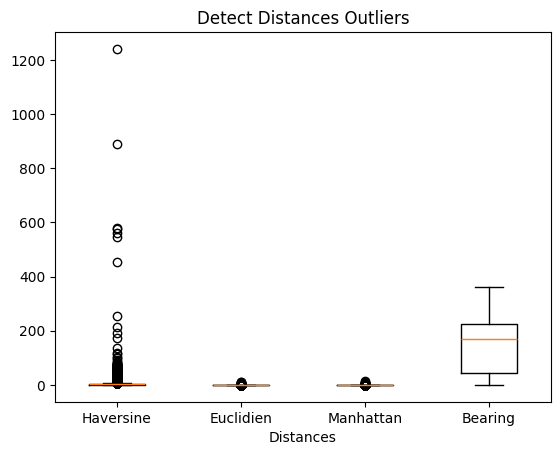

In [25]:
plt.figure()
plt.boxplot([df['haversine_distance'],df['euclidien_distance'],df['manhattan_distance'],df['bearing']])
plt.xlabel('Distances')
plt.xticks([1,2,3,4],['Haversine','Euclidien','Manhattan','Bearing'])
plt.title('Detect Distances Outliers')
plt.show()

In [26]:
def del_ouliers(df,factor=1.5):
    filtered_df = df.copy()
    Q1 = filtered_df['trip_duration'].quantile(0.25)
    Q3 = filtered_df['trip_duration'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    filtered_df = filtered_df[(filtered_df['trip_duration'] >= lower ) & (filtered_df['trip_duration'] <= upper )] 
    print(f'upper bound is {upper} and lower bound is {lower}')
    print(filtered_df.shape)
    return filtered_df

filtered_df = del_ouliers(df,6)

upper bound is 5136.0 and lower bound is -3665.0
(997632, 23)


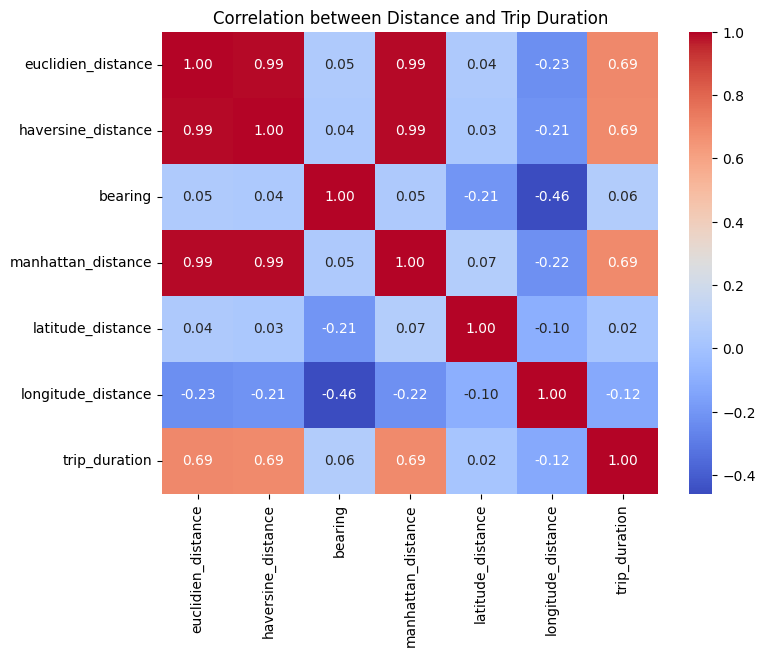

In [27]:
corr = filtered_df[['euclidien_distance','haversine_distance','bearing','manhattan_distance',"latitude_distance" ,"longitude_distance",'trip_duration']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Distance and Trip Duration")

plt.show()

Now we see that the values change 
that is fine correlation between distances and trip duartion

we will use later the haversine distance

## Explore Categorical Features

**Passenger Count**

In [28]:
print(df['passenger_count'].unique())

[1 5 2 4 3 6 0 7]


In [29]:
print(df['passenger_count'].value_counts())

passenger_count
1    708628
2    143907
5     53635
3     41012
6     33287
4     19491
0        38
7         2
Name: count, dtype: int64


the maximum count should be 4,what about 5,6,7 , maybe it differs depending on the taxi provider

0 is incorrect value

In [30]:
print('vendor_id 1',df[df['vendor_id'] == 1]['passenger_count'].value_counts())
print('vendor_id 2',df[df['vendor_id'] == 2]['passenger_count'].value_counts())

vendor_id 1 passenger_count
1    377839
2     63067
3     15706
4      8213
5       249
6       111
0        22
Name: count, dtype: int64
vendor_id 2 passenger_count
1    330789
2     80840
5     53386
6     33176
3     25306
4     11278
0        16
7         2
Name: count, dtype: int64


every vendor id has the same passenger count, so it doesn't depend on it

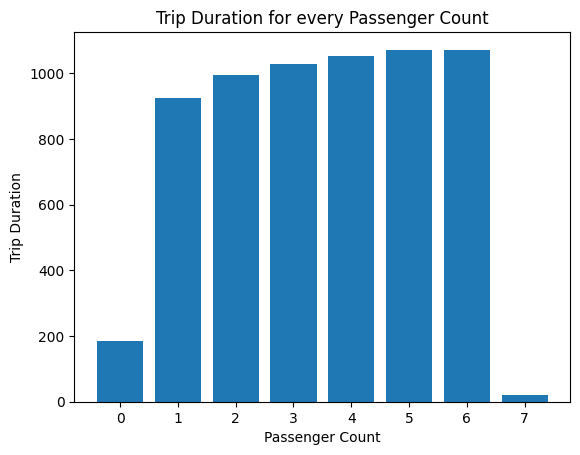

In [31]:
group = df.groupby(df['passenger_count'])['trip_duration'].mean()
plt.bar(group.index,group.values)
plt.xlabel('Passenger Count')
plt.ylabel('Trip Duration')
plt.title('Trip Duration for every Passenger Count')
plt.show()

positive correlation between passenger count and trip duration(when the number of passenger increase , the trip duration increase) exept at 7 which is incorrect value , we will delete it later

**store and fwd flag**

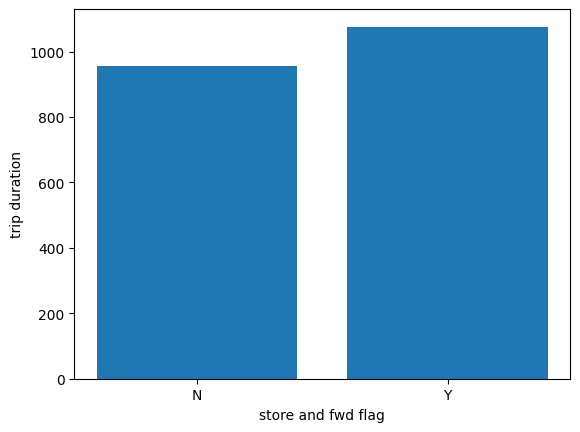

In [32]:
group = df.groupby(df['store_and_fwd_flag'])['trip_duration'].mean()
plt.bar(group.index,group.values)
plt.xlabel('store and fwd flag')
plt.ylabel('trip duration')
plt.show()

the trips stored in the vechicle memory take along time than the other

**vendor id**

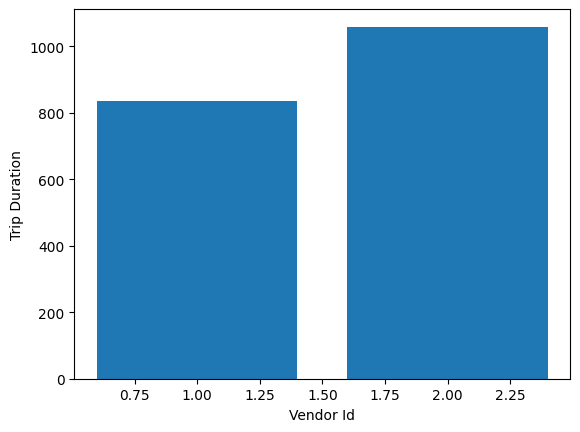

In [33]:
group = df.groupby(df['vendor_id'])['trip_duration'].mean()
plt.bar(group.index,group.values)
plt.xlabel('Vendor Id')
plt.ylabel('Trip Duration')
plt.show()

class 2 of vendor id takes longer trip durations than the other

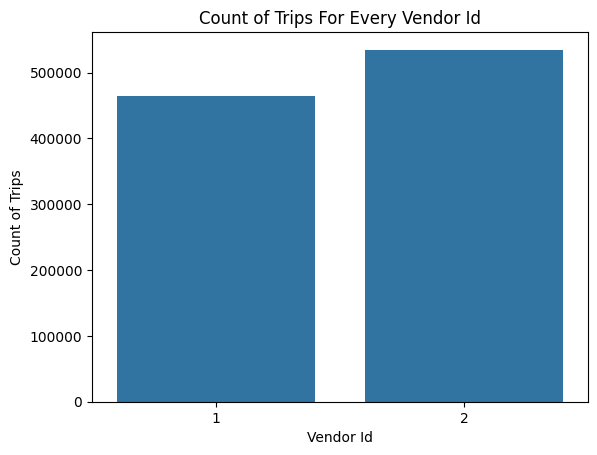

In [34]:
sns.countplot(x='vendor_id', data=df)
plt.xlabel('Vendor Id')
plt.ylabel('Count of Trips')
plt.title('Count of Trips For Every Vendor Id')
plt.show()

class 2 of vendor id has more trips than class 1

## Cluster

In [36]:
from sklearn.cluster import MiniBatchKMeans
# Stack all pickup and dropoff coordinates from train and val sets
coords = np.vstack((
    df[['pickup_latitude', 'pickup_longitude']].values,
    df[['dropoff_latitude', 'dropoff_longitude']].values,
    
))

kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000, random_state=42).fit(coords)

# Predict clusters
df['pickup_cluster']  = kmeans.predict(df[['pickup_latitude','pickup_longitude']].values)
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude','dropoff_longitude']].values)

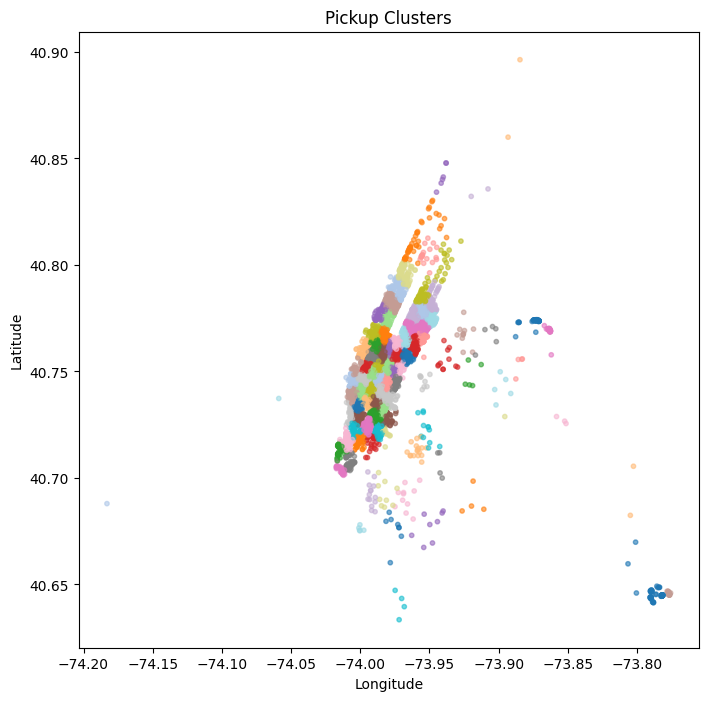

In [37]:
sample = df.sample(5000, random_state=42)

plt.figure(figsize=(8,8))
plt.scatter(sample['pickup_longitude'], sample['pickup_latitude'],
            c=sample['pickup_cluster'], cmap='tab20', s=10, alpha=0.6)
plt.title('Pickup Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

- Target feature (trip_duration) highly right-skewed → log transform applied

- Existence of extreme outliers in trip_duration → removed from train only

- Distance features (haversine, manhattan) show correlation after outlier removal

- Temporal features (hour, weekday, rush hour) have effect on trip duration

- store_and_fwd_flag has noticeable difference in average duration → kept as feature